Complete


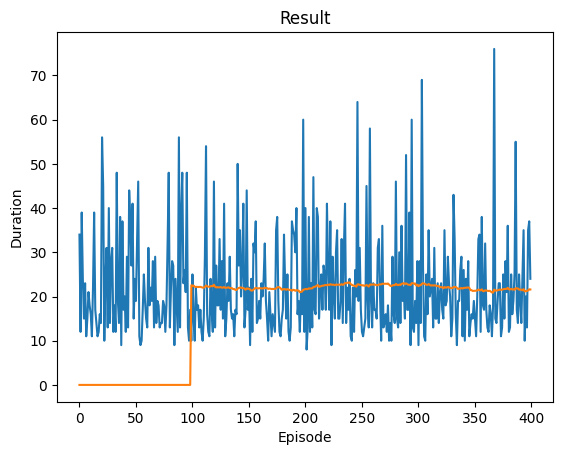

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

env = gym.make('CartPole-v1')

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', 
                         ('state', 'action', 'next_state', 'reward'))

class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.mu_weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        self.sigma_weight = nn.Parameter(torch.ones(out_features, in_features) * sigma_init)

        self.mu_bias = nn.Parameter(torch.randn(out_features) * 0.1)
        self.sigma_bias = nn.Parameter(torch.ones(out_features) * sigma_init)

    def forward(self, x):
        noise_weight = torch.randn_like(self.sigma_weight) * self.sigma_weight
        noise_bias = torch.randn_like(self.sigma_bias) * self.sigma_bias
        weight = self.mu_weight + noise_weight
        bias = self.mu_bias + noise_bias
        return F.linear(x, weight, bias)


class DQN(nn.Module):
    def __init__(self, n_observation, n_action):
        super(DQN, self).__init__()
        self.layer1 = NoisyLinear(n_observation, 128)
        self.layer2 = NoisyLinear(128, 128)
        self.value_stream = NoisyLinear(128, 1)
        self.advantage_stream = NoisyLinear(128, n_action)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        return value + advantage - advantage.mean()


class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
        self.alpha = alpha
        self.priorities = deque([], maxlen=capacity)

    def push(self, *args):
        max_priority = max(self.priorities) if self.memory else 1.0
        self.memory.append(Transition(*args))
        self.priorities.append(max_priority)

    def sample(self, batch_size, beta=0.4):
        priorities = torch.tensor(self.priorities, dtype=torch.float32)
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = torch.multinomial(probs, batch_size, replacement=False)

        batch = [self.memory[i] for i in indices]
        weights = (len(self.memory) * probs[indices]) ** (-beta)
        weights /= weights.max()

        return batch, indices, weights


    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

    
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
            
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    if isinstance(memory, PrioritizedReplayMemory):
        transitions, indices, weights = memory.sample(BATCH_SIZE)
    else:
        transitions = memory.sample(BATCH_SIZE)
        indices, weights = [], []

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # Double DQN: Sử dụng policy_net để chọn hành động, target_net để tính giá trị
        next_state_actions = policy_net(non_final_next_states).max(1).indices
        next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_state_actions.unsqueeze(1)).squeeze(1)

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Calculate importance-sampled loss
    if weights:
        loss = (loss * weights).mean()

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    # Update priorities in memory
    if weights:
        td_errors = (state_action_values - expected_state_action_values.unsqueeze(1)).abs().detach()
        memory.update_priorities(indices, td_errors.cpu().numpy())


 
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 400
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, info = env.step(action.item())
        done = terminated or truncated
        reward = torch.tensor([reward], device=device)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()